# Smart contract analysis
Analyse smart contracts from a MongoDB. To load data into MongoDB use the data-loader package.

In [1]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymongo
from pprint import pprint

mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['axes.titlesize'] = "small"
mpl.rcParams['axes.labelsize'] = "large"

In [2]:
db = pymongo.MongoClient()

## Exploration

In [3]:
db.code.collection_names()

[u'code_base']

In [4]:
# Rather large and thus commented. 
# Uncomment to see an example of the document structure.

# pprint(db.code.code_base.find_one())

Display number of contracts in our collection

In [5]:
code_base = db.code.code_base
code_base.count()

2561

Display graph of code modification date.

In [6]:
from datetime import datetime
def convert_unixtime(timestamp):
    return datetime.utcfromtimestamp(timestamp)

In [7]:
timestamps = code_base.find({},{"date_added":1, "_id":0})
time_list = []
for item in timestamps:
    time = convert_unixtime(item['date_added'])
    time_list.append(time)
oldest = min(time_list)
youngest = max(time_list)
difference = youngest - oldest

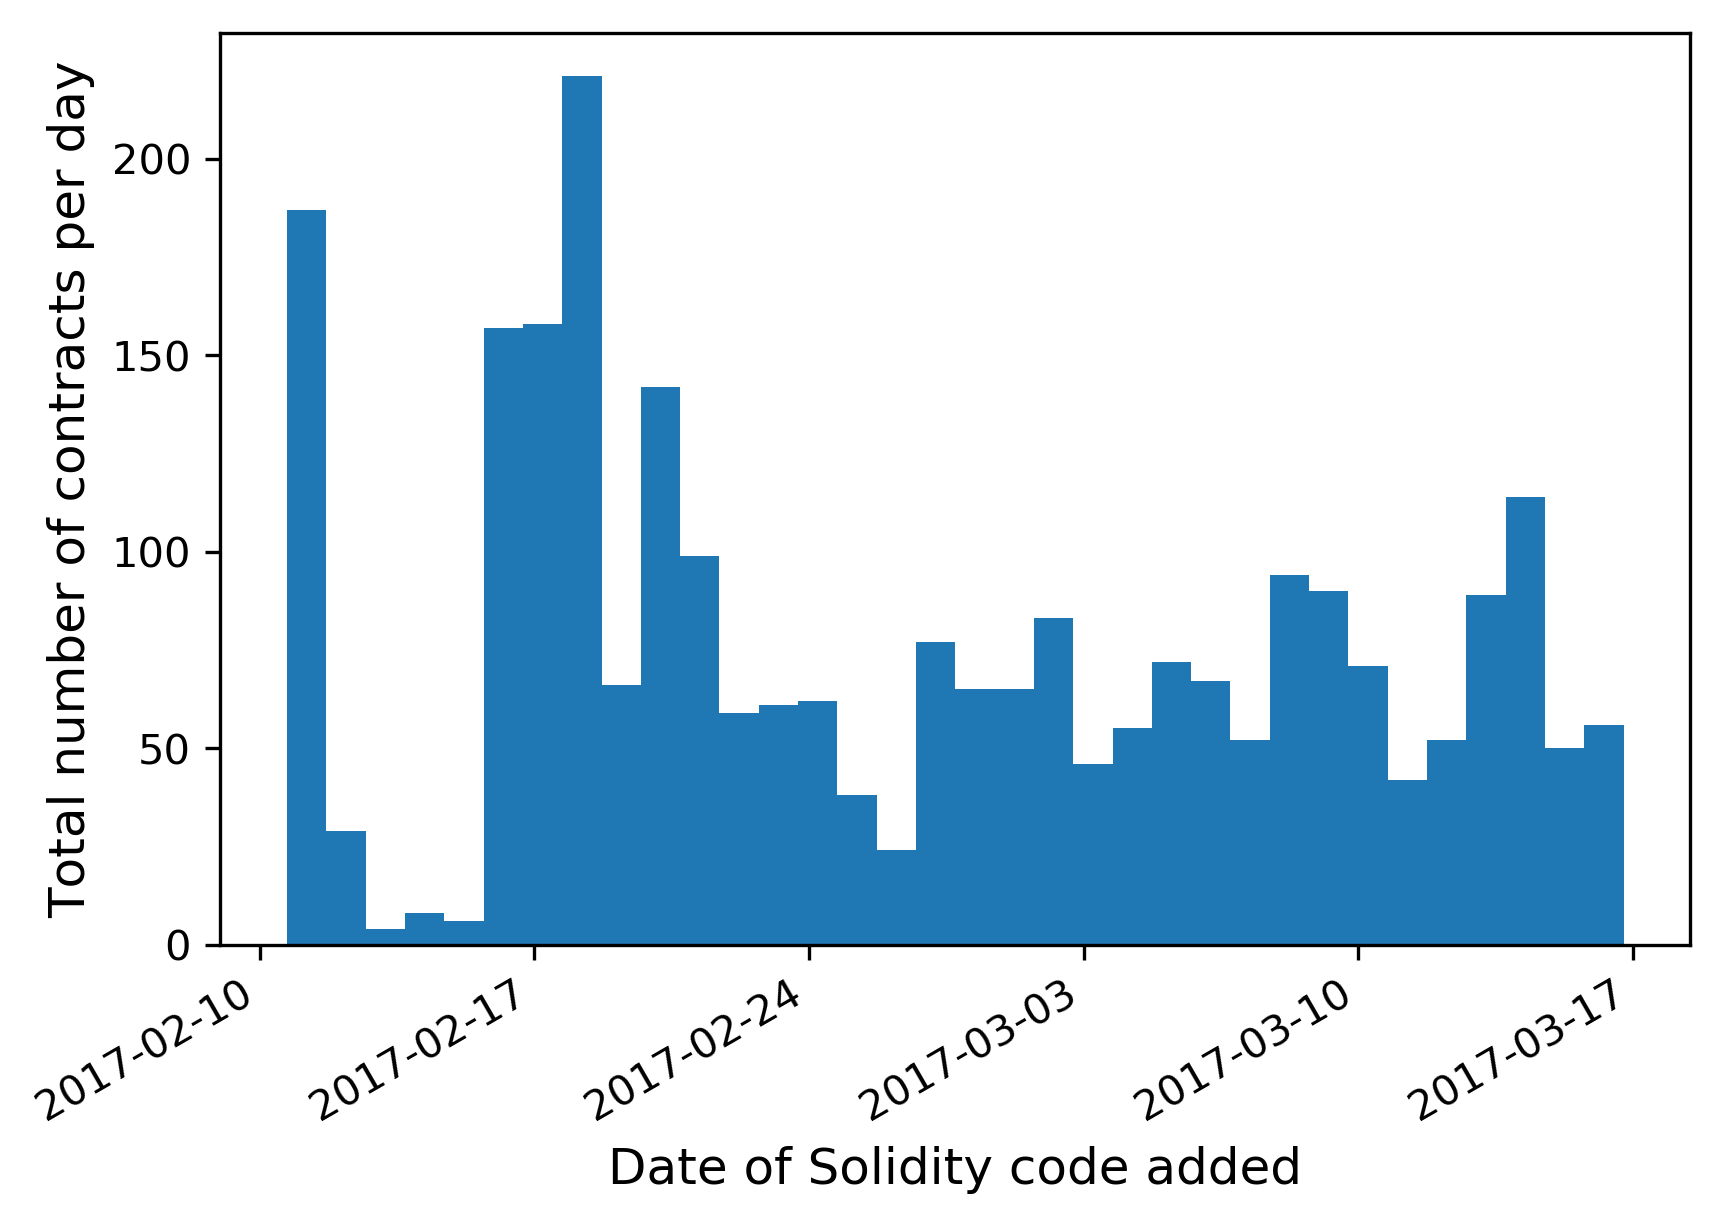

In [8]:
x = time_list
num_bins = difference.days
fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins)
ax.set_xlabel('Date of Solidity code added')
ax.set_ylabel('Total number of contracts per day')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
fig.autofmt_xdate()
plt.show()

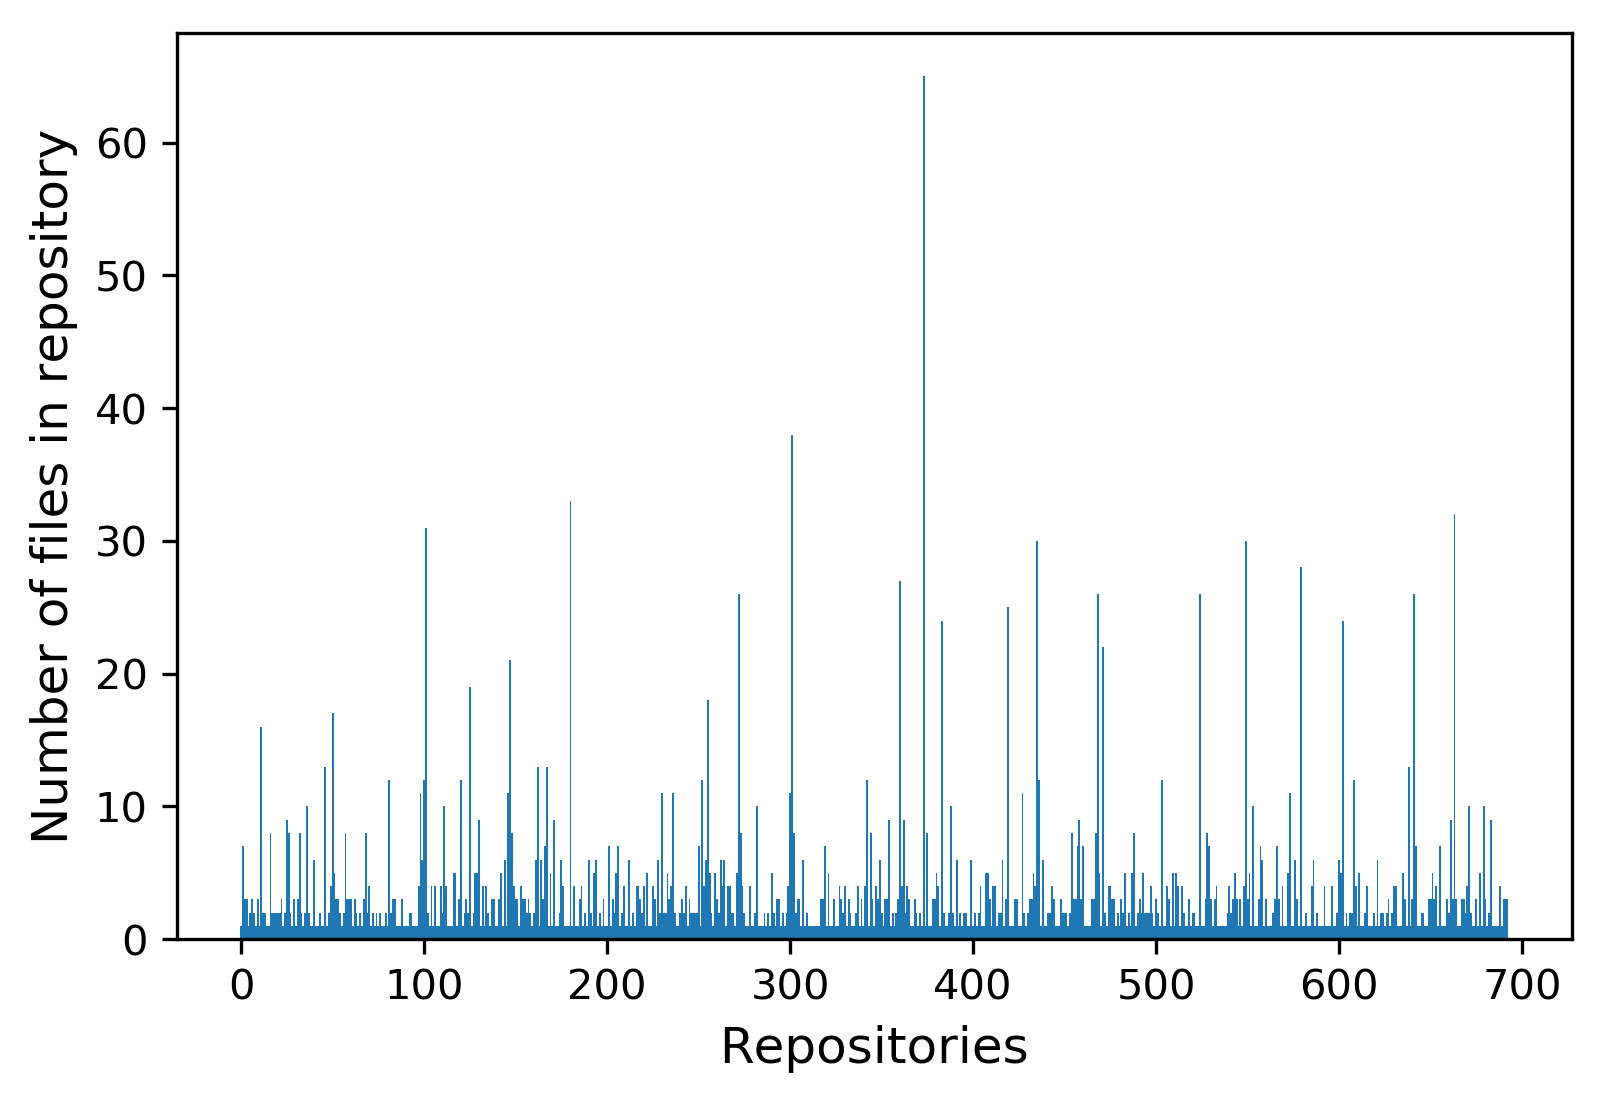

In [28]:
from collections import Counter
import numpy as np
from operator import itemgetter

repositories = code_base.find({},{"repository_id":1, "_id":0})
repo_list = []


for item in repositories:
    repo_list.append(item["repository_id"])
    
repos = Counter(repo_list).items()
repos.sort(key=itemgetter(1), reverse=True)
labels, values = zip(*repos)

indexes = np.arange(len(labels))
width = 1

# the barchart of the data
plt.bar(indexes, values, width)
plt.xlabel('Repositories')
plt.ylabel('Number of files in repository')
plt.show()

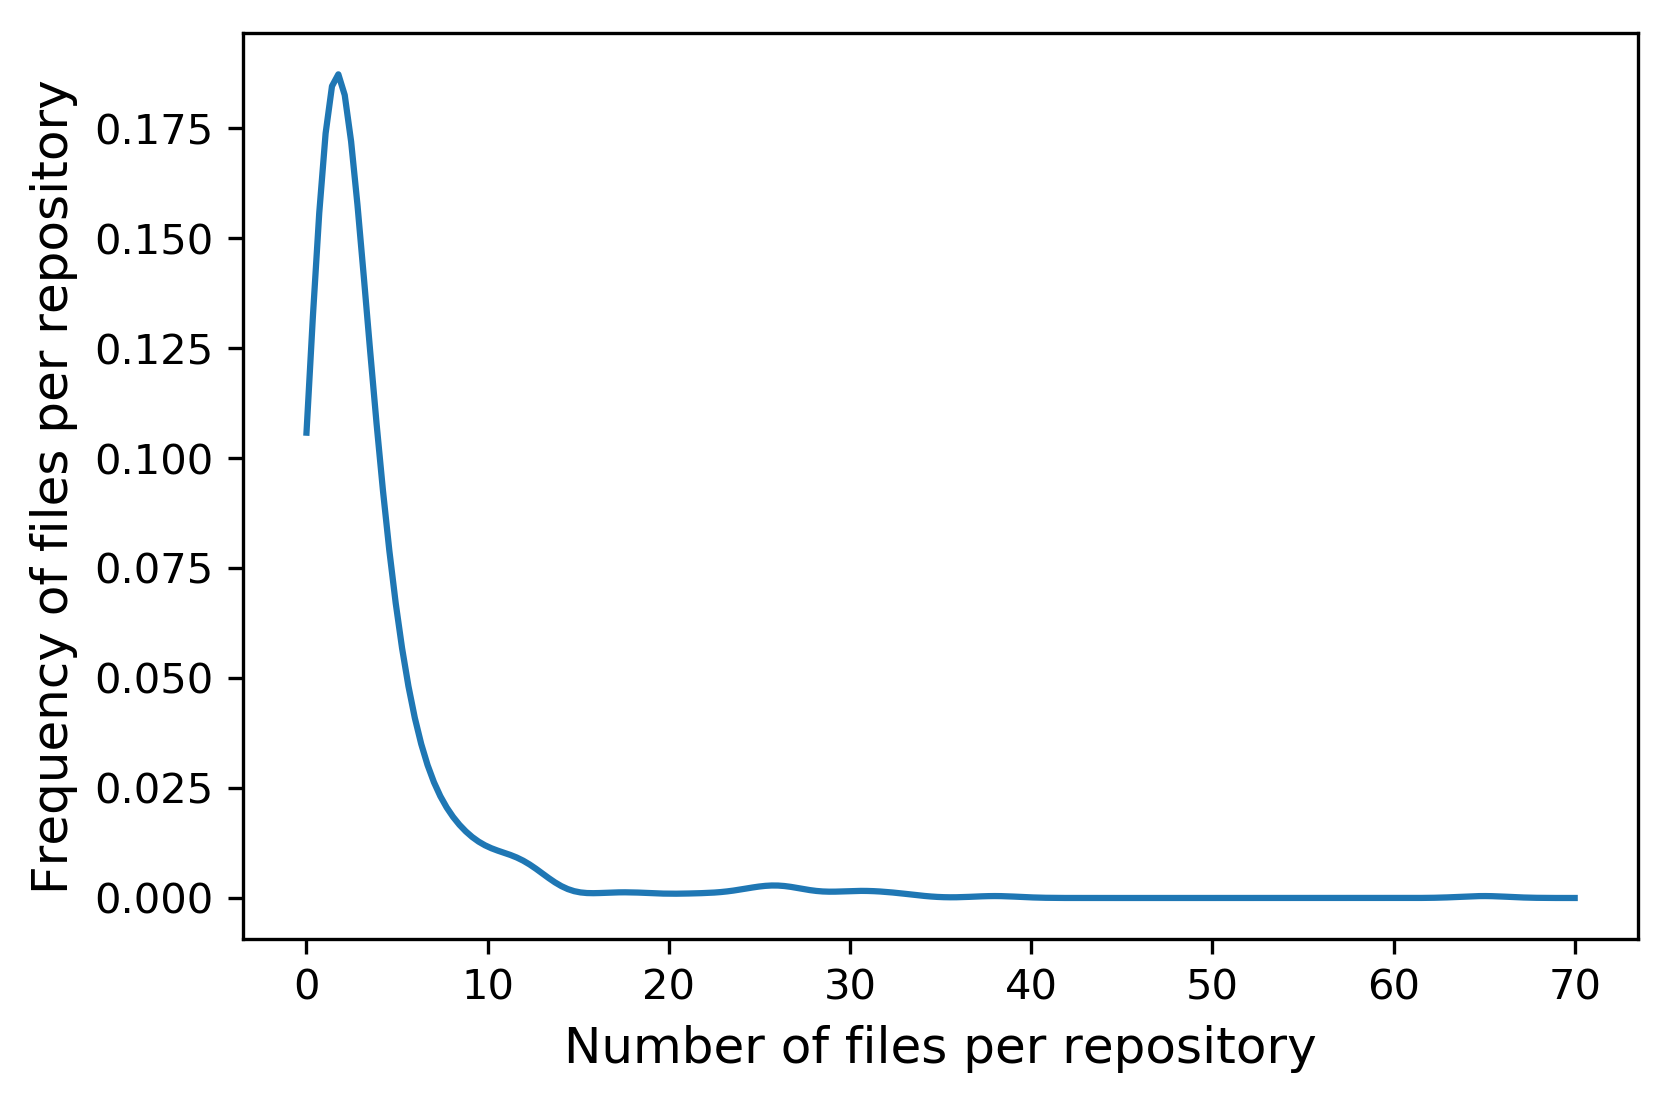

In [38]:
from scipy.stats import gaussian_kde

repositories = code_base.find({},{"repository_id":1, "_id":0})
repo_list = []


for item in repositories:
    repo_list.append(item["repository_id"])
    
repos = Counter(repo_list).items()
labels, values = zip(*repos)

data = values
density = gaussian_kde(data)
xs = np.linspace(0,70,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.xlabel('Number of files per repository')
plt.ylabel('Frequency of files per repository')
plt.show()

In [10]:
from statistics import mean, stdev, variance

print "Mean: {}".format(mean(values))
print "Standard deviation: {}".format(stdev(values))
print "Variance: {}".format(variance(values))
print "Total: {}".format(len(values))

Mean: 3.69552669553
Standard deviation: 5.26559837088
Variance: 27.7265262034
Total: 693


### Solidity versions

In [11]:
# Find akeys in nested dictinaries
# Interesting thread on this: http://stackoverflow.com/questions/9807634/find-all-occurences-of-a-key-in-nested-python-dictionaries-and-lists
def gen_dict_extract(key, var):
    if hasattr(var,'iteritems'):
        for k, v in var.iteritems():
            if k == key:
                yield v
            if isinstance(v, dict):
                for result in gen_dict_extract(key, v):
                    yield result
            elif isinstance(v, list):
                for d in v:
                    for result in gen_dict_extract(key, d):
                        yield result

In [12]:
sol_code = code_base.find({},{"code":1, "_id":0})
sol_list = []

for item in sol_code:
    try:
        version = gen_dict_extract("version", item)
        sol_list.append(list(version)[0])
        # sol_list.append(item["code"]["body"][0]["start_version"]["version"])
    except KeyError:
        pass
    except IndexError:
        pass
# Print number of contracts that include a Solidity version
print len(sol_list)

2074


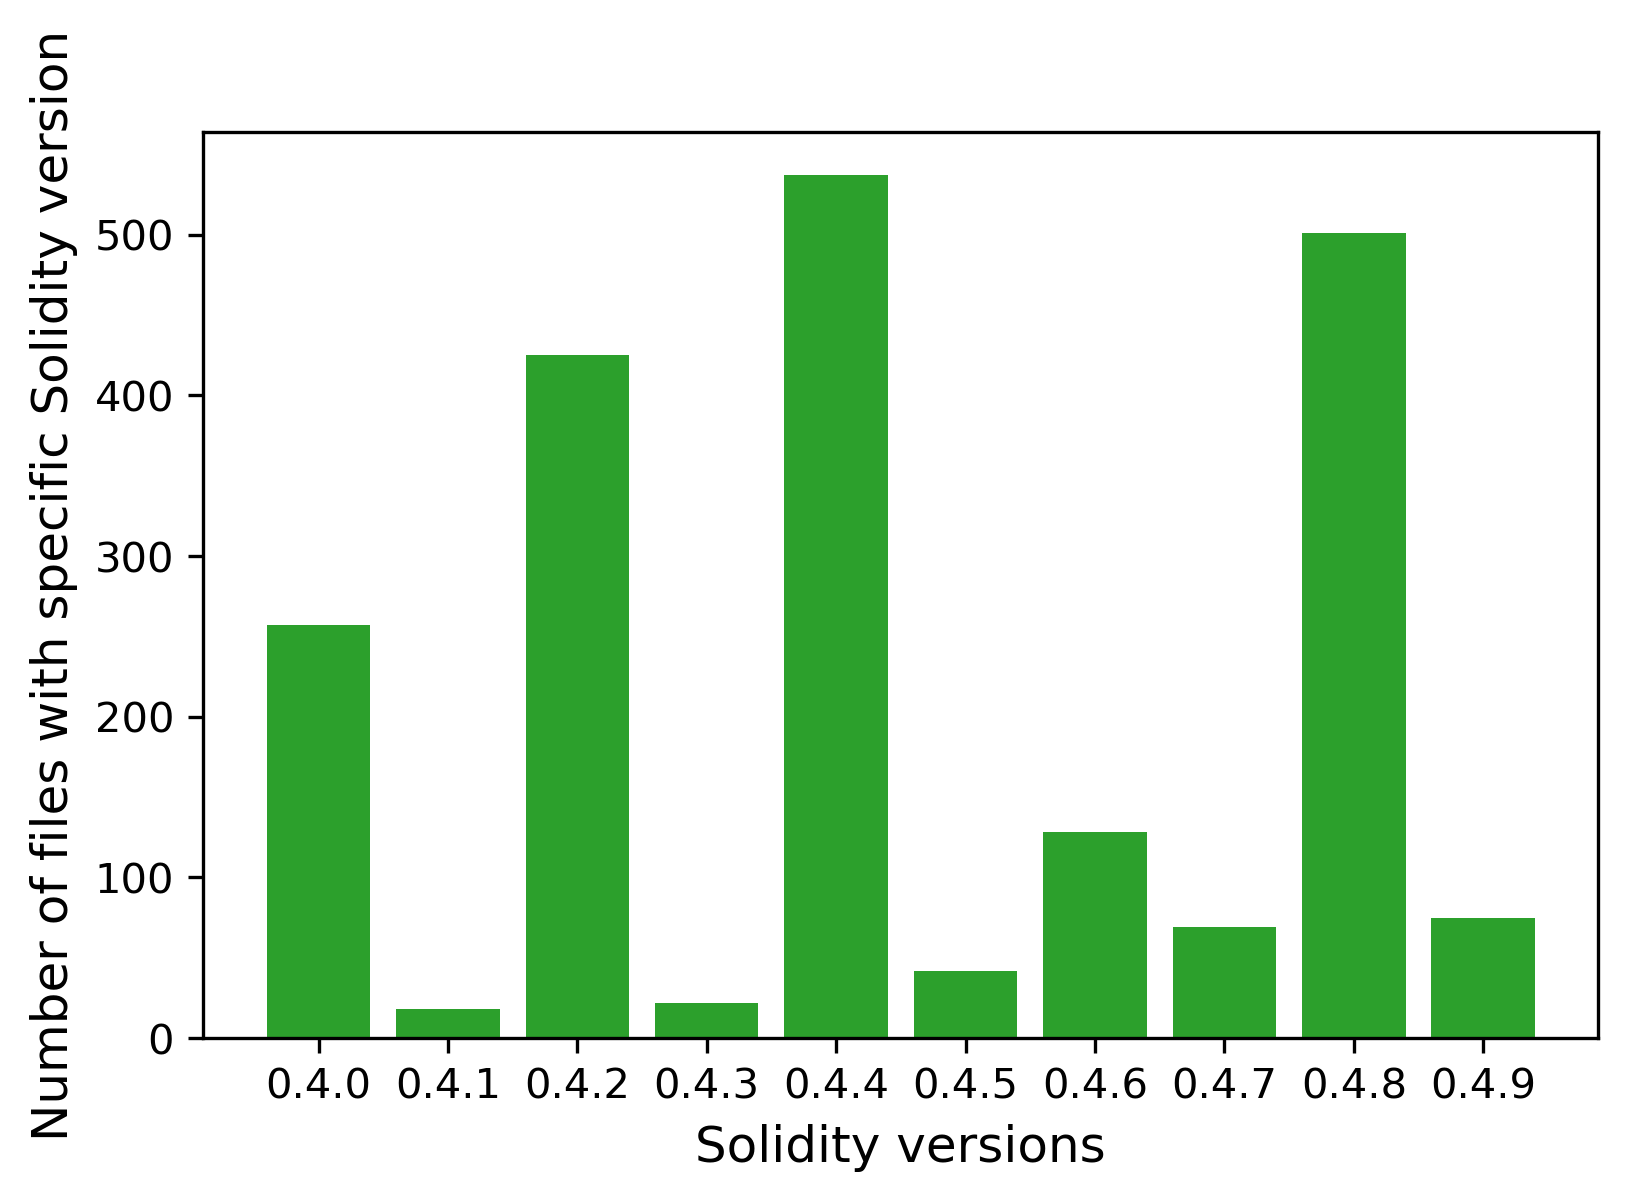

In [37]:
versions = Counter(sol_list).items()
versions.sort(key=itemgetter(0))
labels, values = zip(*versions)

indexes = np.arange(len(labels))
width = 0.8

# the barchart of the data
plt.bar(indexes, values, width)
plt.xlabel('Solidity versions')
plt.ylabel('Number of files with specific Solidity version')
plt.xticks(indexes, labels)
plt.show()

# Analysis of security recommendations
Based on [best pratices by ConsenSys](https://github.com/ConsenSys/smart-contract-best-practices#solidity-tips)

# Analysis of code complexity
Number of variables, mappings, structs, and events per contract

In [14]:
sol_code = code_base.find({},{"code":1, "_id":0})

variables = []
structs = []
events = []
mappings = []
functions = []
libraries = []
enums = []
imports = []

for item in sol_code:
    current_variables = 0
    current_structs = 0
    current_events = 0
    current_mappings = 0
    current_functions = 0
    current_libraries = 0
    current_enums = 0
    current_imports = 0
    for key in gen_dict_extract('type', item):
        if key in 'StateVariableDeclaration':
            current_variables += 1
        elif key in 'StructDeclaration':
            current_structs += 1
        elif key in 'EventDeclaration':
            current_events += 1
        elif key in 'MappingExpression':
            current_mappings += 1
        elif key in 'FunctionDeclaration':
            current_functions += 1
        elif key in 'UsingStatement':
            current_libraries += 1
        elif key in 'EnumDeclaration':
            current_enums += 1
        elif key in 'ImportStatement':
            current_imports += 1     
    variables.append(current_variables)
    structs.append(current_structs)
    events.append(current_events)
    mappings.append(current_mappings)
    functions.append(current_functions)
    libraries.append(current_libraries)
    enums.append(current_enums)
    imports.append(current_imports)
    
all_data = [imports, libraries, variables, events, structs, mappings, enums, functions]

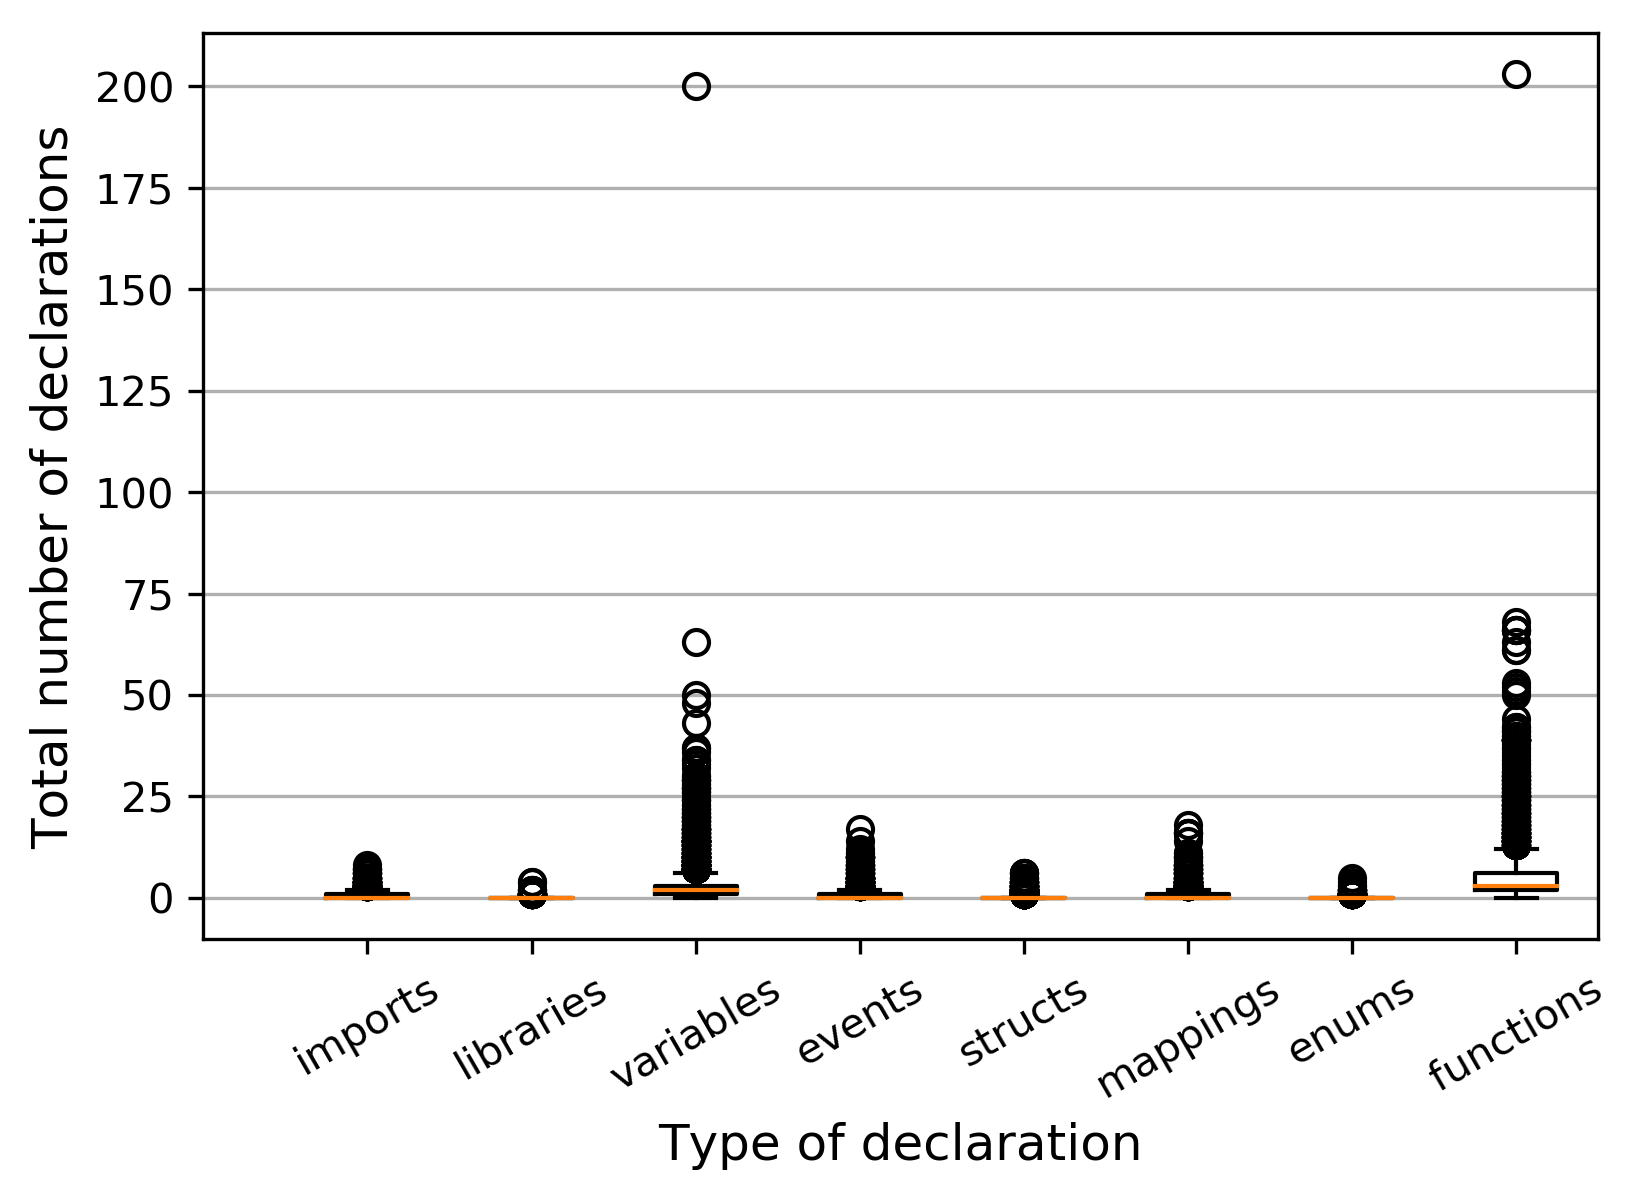

In [15]:
fig, axes = plt.subplots()

axes.boxplot(all_data)

xlabels = ['imports', 'libraries', 'variables', 'events', 'structs', 'mappings', 'enums', 'functions']

axes.yaxis.grid(True)
axes.set_xticks([y for y in range(len(all_data))])
axes.set_xlabel('Type of declaration')
axes.set_ylabel('Total number of declarations')
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=xlabels)
plt.xticks(rotation=30)
plt.show()

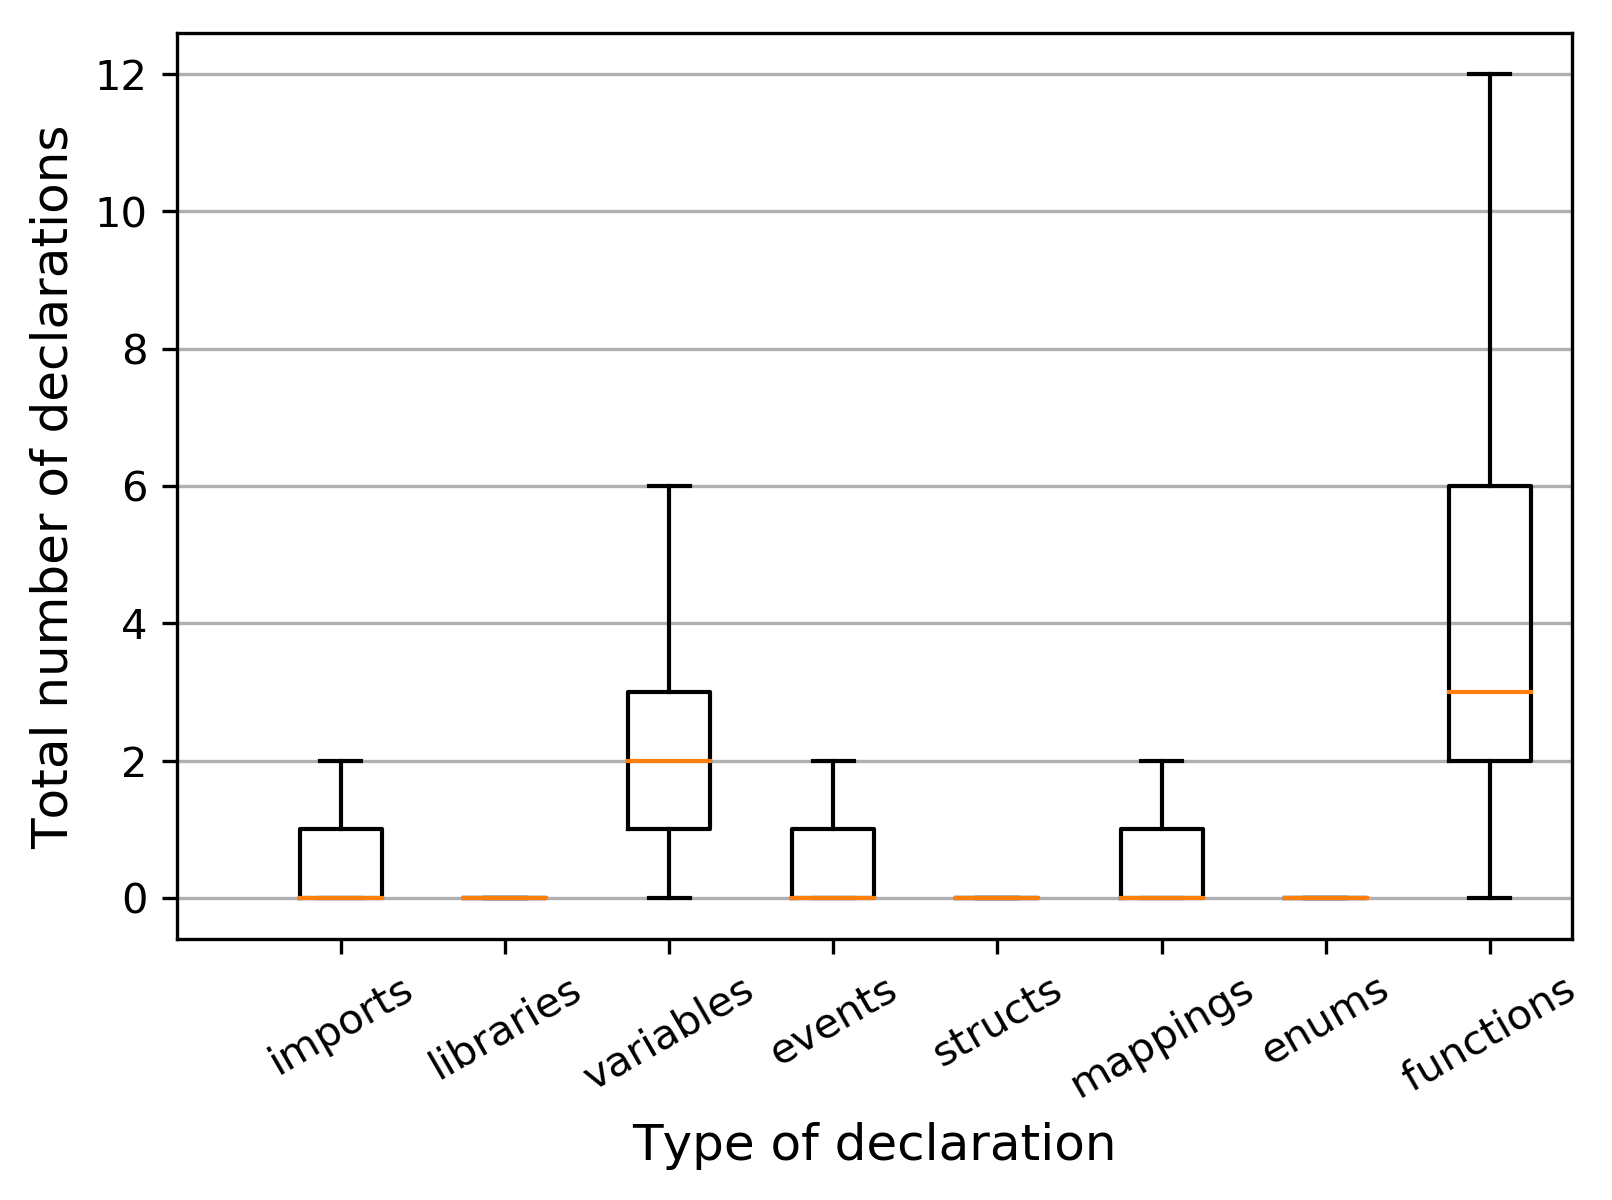

In [16]:
fig, axes = plt.subplots()

axes.boxplot(all_data, showfliers=False)

xlabels = ['imports', 'libraries', 'variables', 'events', 'structs', 'mappings', 'enums', 'functions']

axes.yaxis.grid(True)
axes.set_xticks([y for y in range(len(all_data))])
axes.set_xlabel('Type of declaration')
axes.set_ylabel('Total number of declarations')
plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=xlabels)
plt.xticks(rotation=30)
plt.show()

In [17]:
from statistics import mean, stdev, variance
i = 0
for item in all_data:
    print xlabels[i]
    print "Mean: {}".format(mean(item))
    print "Standard deviation: {}".format(stdev(item))
    print "Variance: {}".format(variance(item))
    print "Outer 90 percentile: {}".format(np.percentile(item,90))
    print "Outer 95 percentile: {}".format(np.percentile(item,95))
    print "Outer 99 percentile: {}".format(np.percentile(item,99))
    print "-------------"
    i += 1

imports
Mean: 0.646231940648
Standard deviation: 1.08027161989
Variance: 1.16698677275
Outer 90 percentile: 2.0
Outer 95 percentile: 3.0
Outer 99 percentile: 5.0
-------------
libraries
Mean: 0.0171807887544
Standard deviation: 0.17144155037
Variance: 0.0293922051933
Outer 90 percentile: 0.0
Outer 95 percentile: 0.0
Outer 99 percentile: 1.0
-------------
variables
Mean: 3.33346349082
Standard deviation: 6.3921100713
Variance: 40.8590711636
Outer 90 percentile: 8.0
Outer 95 percentile: 14.0
Outer 99 percentile: 26.4
-------------
events
Mean: 0.633346349082
Standard deviation: 1.49592052317
Variance: 2.23777821164
Outer 90 percentile: 2.0
Outer 95 percentile: 3.0
Outer 99 percentile: 8.0
-------------
structs
Mean: 0.240531042561
Standard deviation: 0.679450857593
Variance: 0.461653467884
Outer 90 percentile: 1.0
Outer 95 percentile: 2.0
Outer 99 percentile: 3.0
-------------
mappings
Mean: 0.689183912534
Standard deviation: 1.50059758856
Variance: 2.2517931228
Outer 90 percentile: 2.0


# Security analysis

In [18]:
security_status = code_base.find({"security": {"$exists": True}},{"security":1, "_id":0})
security_stats = [0,0,0,0]
security_issues = [0,0,0,0]

for status in security_status:
    this_status = status["security"]
    if "callstack" in this_status:
        security_stats[0] += 1
        if this_status["callstack"]:
            security_issues[0] += 1
    if "time_dependency" in this_status:
        security_stats[1] += 1
        if this_status["time_dependency"]:
            security_issues[1] += 1
    if "reentrancy" in this_status:
        security_stats[2] += 1
        if this_status["reentrancy"]:
            security_issues[2] += 1
    if "concurrency" in this_status:
        security_stats[3] += 1
        if this_status["concurrency"]:
            security_issues[3] += 1

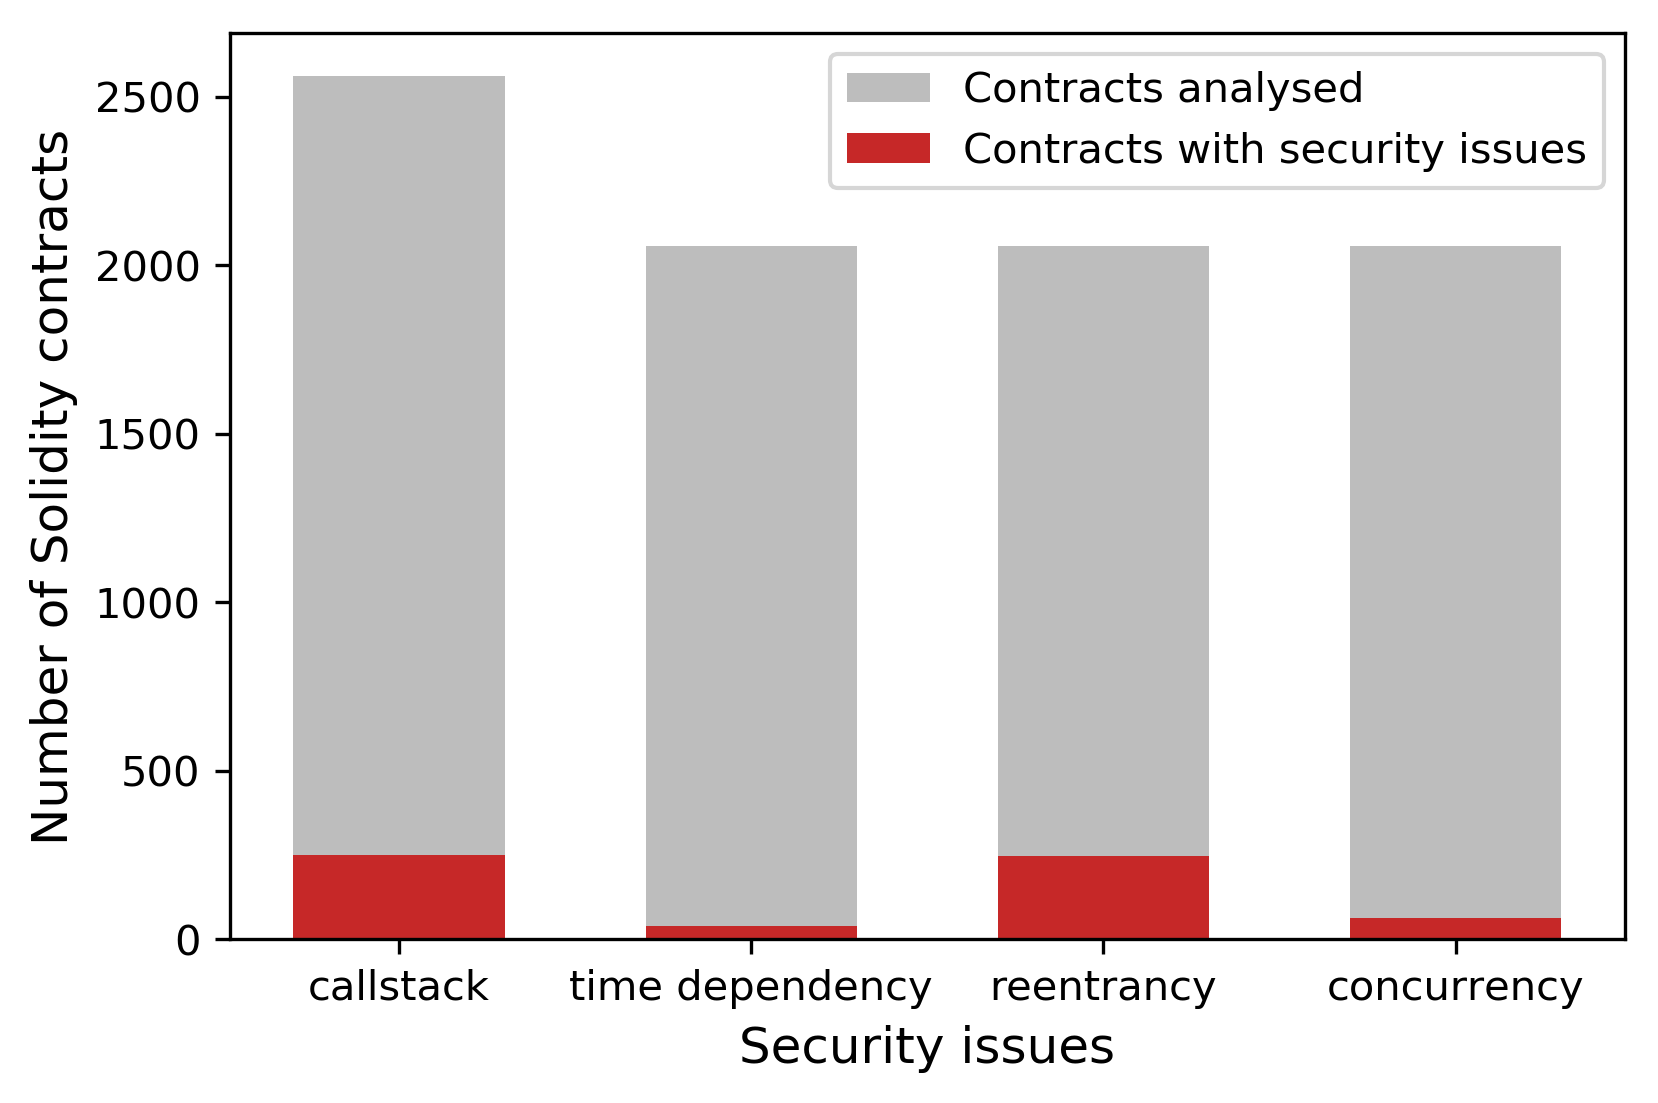

In [19]:
labels = ["callstack", "time dependency", "reentrancy", "concurrency"]

indexes = np.arange(len(labels))
width = 0.6

# the barchart of the data
plt.bar(indexes, security_stats, width, color='#bdbdbd', label='Contracts analysed')
plt.bar(indexes, security_issues, width, color='#c62828', label='Contracts with security issues')
plt.xlabel('Security issues')
plt.ylabel('Number of Solidity contracts')
plt.xticks(indexes, labels)
plt.legend()
plt.show()

In [20]:
print security_issues
print security_stats

[250, 38, 246, 64]
[2561, 2057, 2057, 2057]
